# Project 4: Multi-factor Model
## Instructions
Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. After implementing the function, run the cell to test it against the unit tests we've provided. For each problem, we provide one or more unit tests from our `project_tests` package. These unit tests won't tell you if your answer is correct, but will warn you of any major errors. Your code will be checked for the correct solution when you submit it to Udacity.

## Packages
When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

The other packages that we're importing are `project_helper` and `project_tests`. These are custom packages built to help you solve the problems.  The `project_helper` module contains utility functions and graph functions. The `project_tests` contains the unit tests for all the problems.

### Install Packages
You can view the list of packages to install, as mentioned in `requirements.txt` as:

`! cat requirements.txt` 

In [6]:
%%capture
%run 01_portopt_data.ipynb

### Load Packages

In [1]:
import cvxpy as cvx
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

# Statistical Risk Model

In [16]:
risk_model.keys()

dict_keys(['idiosyncratic_var_vector', 'factor_var_vector', 'factor_betas', 'factor_returns'])

In [11]:
risk_model['factor_betas'].shape

(490, 20)

In [22]:
risk_model['factor_cov_matrix'] = np.diag(risk_model['factor_var_vector']['0'].values)
risk_model['factor_cov_matrix'].shape

(20, 20)

In [23]:
risk_model['idiosyncratic_var_vector'].shape

(490, 1)

# Create Alpha Factors

In [25]:
ml_alpha_rank = ml_alpha.groupby(level=0).apply(
    lambda grp: pd.cut(grp, bins=np.linspace(start=grp.min(), stop=grp.max(), num=11), labels=False, include_lowest=True))
#ml_alpha_rank = ml_alpha.groupby(level=0).transform(lambda x: scipy.stats.rankdata(x))
mu = ml_alpha_rank.groupby(level=0).transform(np.mean)
std = ml_alpha_rank.groupby(level=0).transform(np.std)
ml_alpha_rank_zscore = (ml_alpha_rank - mu)/std

In [26]:
# alphas
alpha_factors = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed']
B_alpha = features_df[alpha_factors].copy()
B_alpha['ML_FACTOR'] = ml_alpha
B_alpha['ML_FACTOR_RZ'] = ml_alpha_rank_zscore
B_alpha['COMBI_FACTOR'] = B_alpha[alpha_factors].mean(axis=1)

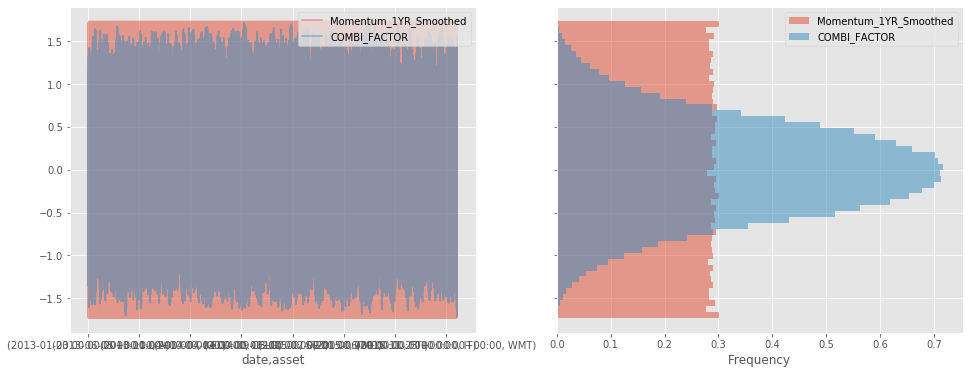

In [30]:
fig, axs = plt.subplots(1,2, figsize=(16,6), sharey=True)
ax1, ax2 = axs
B_alpha[['Momentum_1YR_Smoothed', 'COMBI_FACTOR']].plot(ax=ax1, alpha=0.5)
B_alpha[['Momentum_1YR_Smoothed', 'COMBI_FACTOR']].plot.hist(ax=ax2, bins=50, alpha=0.5, density=True, orientation='horizontal')
plt.show()

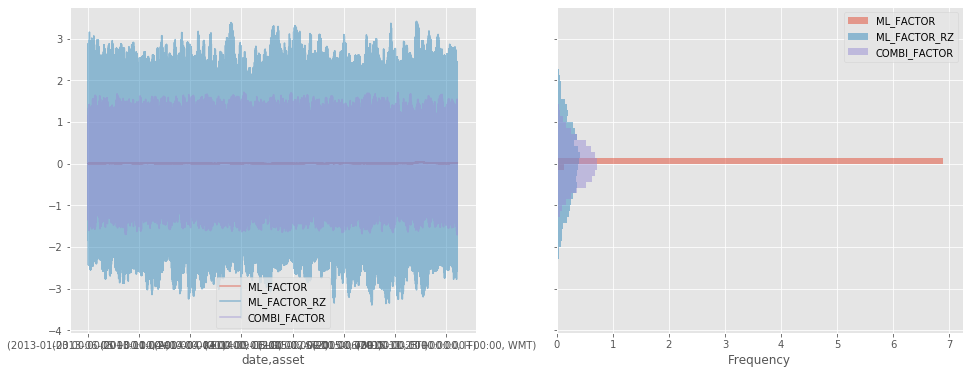

In [31]:
fig, axs = plt.subplots(1,2, figsize=(16,6), sharey=True)
ax1, ax2 = axs

B_alpha[['ML_FACTOR', 'ML_FACTOR_RZ', 'COMBI_FACTOR']].plot(ax=ax1, alpha=0.5)
B_alpha[['ML_FACTOR', 'ML_FACTOR_RZ', 'COMBI_FACTOR']].plot.hist(ax=ax2, bins=50, alpha=0.5, density=True, orientation='horizontal')

plt.show()

In [32]:
B_alpha[['ML_FACTOR', 'ML_FACTOR_RZ', 'COMBI_FACTOR']].isna().sum()

ML_FACTOR       0
ML_FACTOR_RZ    0
COMBI_FACTOR    0
dtype: int64

In [42]:
alpha_vector = B_alpha.loc[test_start, ['ML_FACTOR_RZ']].reset_index(level=0, drop=True).copy()
pd.concat([alpha_vector.head(2), alpha_vector.tail(2)], axis=0)


,ML_FACTOR_RZ
asset,
A,1.864453
AAL,1.864453
ZION,0.073840
ZTS,0.670711


# Optimal Portfolio Constrained by Risk Model
You have an alpha model and a risk model. Let's find a portfolio that trades as close as possible to the alpha model but limiting risk as measured by the risk model. You'll be building thie optimizer for this portfolio. To help you out. we have provided you with an abstract class called `AbstractOptimalHoldings`.

In [69]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T @ weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)

    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints
Using this class as a base class, you'll implement the `OptimalHoldings` class. There's two functions that need to be implemented in this class, the `_get_obj` and `_get_constraints` functions.

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [70]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        alpha_term = alpha_vector.values.flatten() @ weights

        return cvx.Minimize(-alpha_term)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        constraints = [
            risk <= self.risk_cap**2, # risk constraint
            factor_betas.T @ weights <= self.factor_max,  # factor exposures constraints
            factor_betas.T @ weights >= self.factor_min,
            weights <= self.weights_max,  # constraints on allocations
            weights >= self.weights_min,
            cvx.sum(cvx.abs(weights)) <= 1.0,  # leverage
            cvx.sum(weights) == 0.0,  # market neutral
        ]
        
        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

### View Data
With the `OptimalHoldings` class implemented, let's see the weights it generates.

C:\ProgramData\Anaconda3\envs\quant-tsa\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


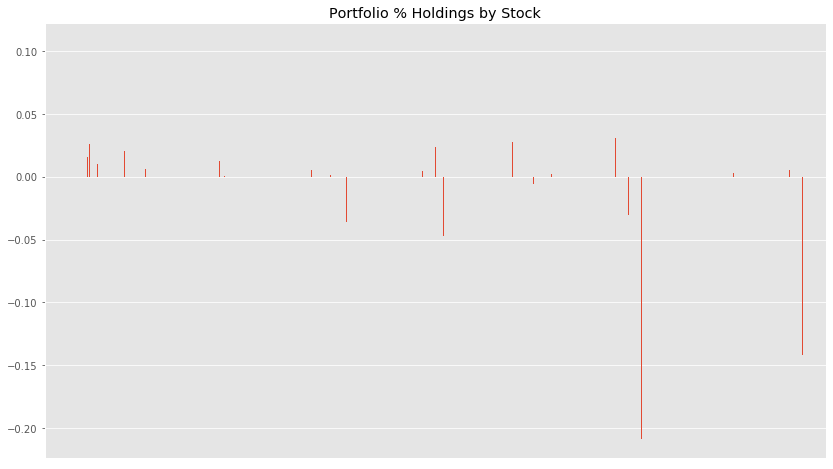

In [71]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [72]:
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

In [73]:
dollar_pnl0 = partial_dot_product(v=optimal_weights[0], w=daily_returns.loc[test_start])
dollar_pnl0.sum()

0.00029611689704023736

## Optimize with a Regularization Parameter
In order to enforce diversification, we'll use regularization in the objective function. We'll create a new class called `OptimalHoldingsRegualization` which gets its constraints from the `OptimalHoldings` class. In this new class, implement the `_get_obj` function to return a CVXPY objective function that maximize $ \alpha^T * x + \lambda\|x\|_2\\ $, where $ x $ is the portfolio weights, $ \alpha $ is the alpha vector, and $ \lambda $ is the regularization parameter.

**Note:** * $ \lambda $ is located in `self.lambda_reg`. *

In [62]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        alpha_term = alpha_vector.values.flatten() @ weights
        reg_term = self.lambda_reg * cvx.norm(weights, 2)
        return cvx.Minimize(- alpha_term + reg_term )

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min


### View Data

C:\ProgramData\Anaconda3\envs\quant-tsa\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


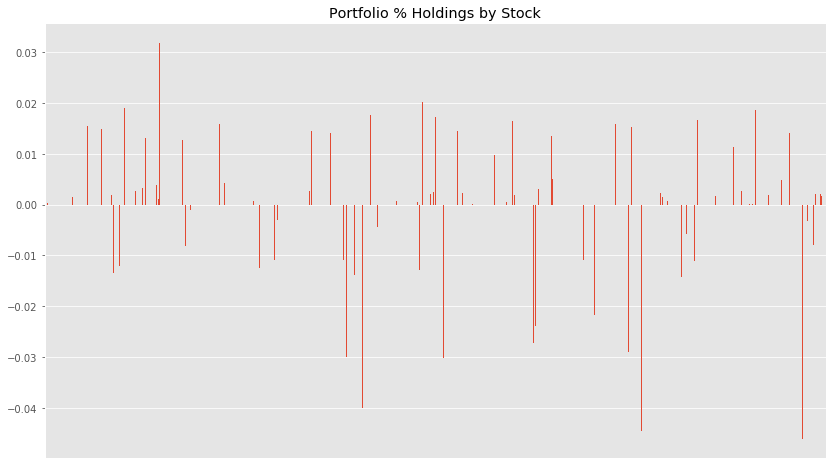

In [63]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

In [65]:
dollar_pnl1 = partial_dot_product(v=optimal_weights_1[0], w=daily_returns.loc[test_start])
dollar_pnl1.sum()

0.0015673000623449276

Nice. Well diversified.

## Optimize with a Strict Factor Constraints and Target Weighting
Another common formulation is to take a predefined target weighting, $x^*$ (e.g., a quantile portfolio), and solve to get as close to that portfolio while respecting portfolio-level constraints. For this next class, `OptimalHoldingsStrictFactor`, you'll implement the `_get_obj` function to minimize on on $ \|x - x^*\|_2 $, where $ x $ is the portfolio weights  $ x^* $ is the target weighting.

In [67]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        x_star = ((alpha_vector-alpha_vector.mean())/alpha_vector.abs().sum()).values.reshape(-1)

        return cvx.Minimize(cvx.norm(weights-x_star, 2))

### View Data

C:\ProgramData\Anaconda3\envs\quant-tsa\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


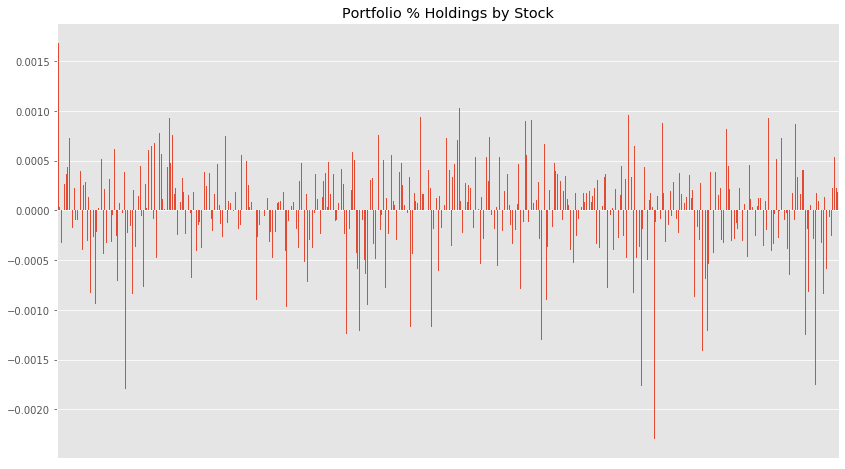

In [68]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.